<a href="https://colab.research.google.com/github/Karishma73/Ant-Colony-Optimization/blob/master/Project_SAO.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container{max-width:80%!important;width:auto!important;}</style>"))
from scipy.spatial.distance import pdist, squareform
from pprint import PrettyPrinter as pp
from math import atan2
from itertools import permutations, count
import math
from datetime import datetime

In [ ]:
Data_link=pd.read_csv('SaO_Optilandia_links.csv')
data_link=Data_link.copy()

In [ ]:
Data=pd.read_csv('SaO_Optilandia_locations.csv')
data=Data.copy()

In [ ]:
fp=open('SaO_Optilandia_depot_lorries.json','r')
jData=json.load(fp)

In [ ]:
jdata=jData.copy()

Graph 

In [ ]:
import networkx as nx

In [ ]:
dist_eucl =squareform(pdist(data[['x','y']]))

In [ ]:
edges  = [(id1,id2,dist_eucl[id1,id2]) for _,(id1,id2) in data_link.iterrows()]

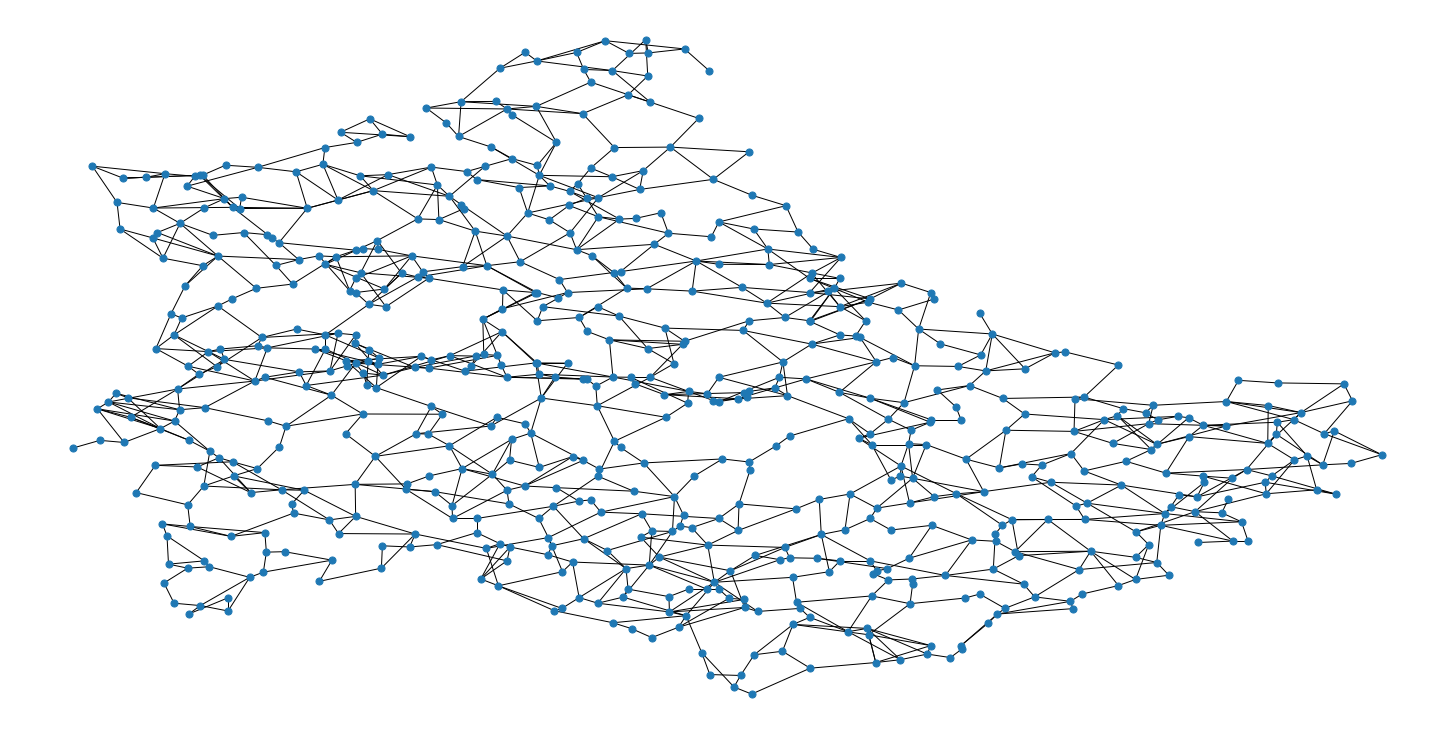

In [ ]:
G = nx.Graph()
G.add_weighted_edges_from(edges)
pos = dict([(j.id, (j.x, j.y)) for j in data.itertuples()])
plt.figure(figsize=(20,10))
nx.draw(G,with_labels=False,pos=pos,node_size=50) 

In [ ]:
cust_loc_ids = data[data.is_customer].iloc[:, 0] # will be used at time of allocation
depot_loc_ids = data[data.is_depot].iloc[:, 0]

In [ ]:
customer=data[data['is_customer']==True]
cus=customer['is_customer']
#cus

In [ ]:
Depot=data[data['is_depot']==True]
Depo=Depot['is_depot']
#Depo

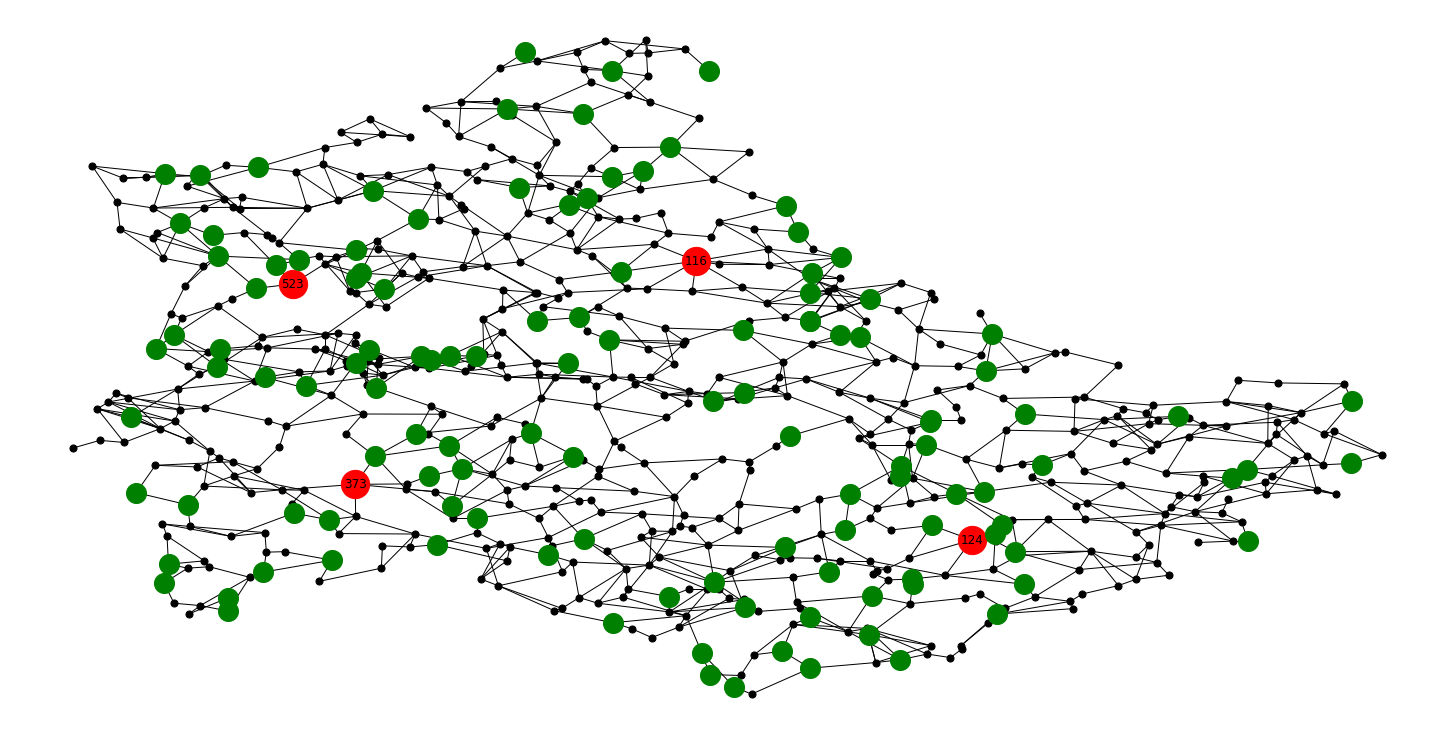

In [ ]:
plt.figure(figsize=(20,10))
nx.draw(G,with_labels=False,node_color='k',pos=pos,node_size=50)
nx.draw_networkx_nodes(G,pos,nodelist=depot_loc_ids,node_color='r',node_size=800,alpha=1,);
nx.draw_networkx_labels(G,pos,{k:k for k in depot_loc_ids});
nx.draw_networkx_nodes(G,pos,nodelist=cust_loc_ids,node_color='g',node_size=400,alpha=1);

Reducing Graph

In [ ]:
Gr1 = G.copy()
nonroad_ids = data[data.is_customer | data.is_depot].iloc[:, 0]
road_loc_ids = data[~data.is_customer & ~data.is_depot].iloc[:, 0]
paths = []

for i, begin in enumerate(list(nonroad_ids)[:-1]):
    for end in list(nonroad_ids)[i + 1 :]:
        paths.append(
            nx.single_source_dijkstra(Gr1, begin, end, weight="weight")
        )

for d, p in paths:
    is_road = [n in list(road_loc_ids) for n in p]
    change = [is_road[i] == is_road[i + 1] for i in range(len(p) - 1)]
    change_inds = [i for i, b in enumerate(change) if not b]
    new_edge_ends = [
        (change_inds[2 * i], change_inds[2 * i + 1] + 1)
        for i in range(len(change_inds) // 2)
    ]

    for ends in new_edge_ends:
        weight = sum([Gr1[p[i]][p[i + 1]]["weight"] for i in range(*ends)])
        Gr1.add_edge(p[ends[0]], p[ends[1]], weight=weight)

Gr1.remove_nodes_from(list(road_loc_ids))

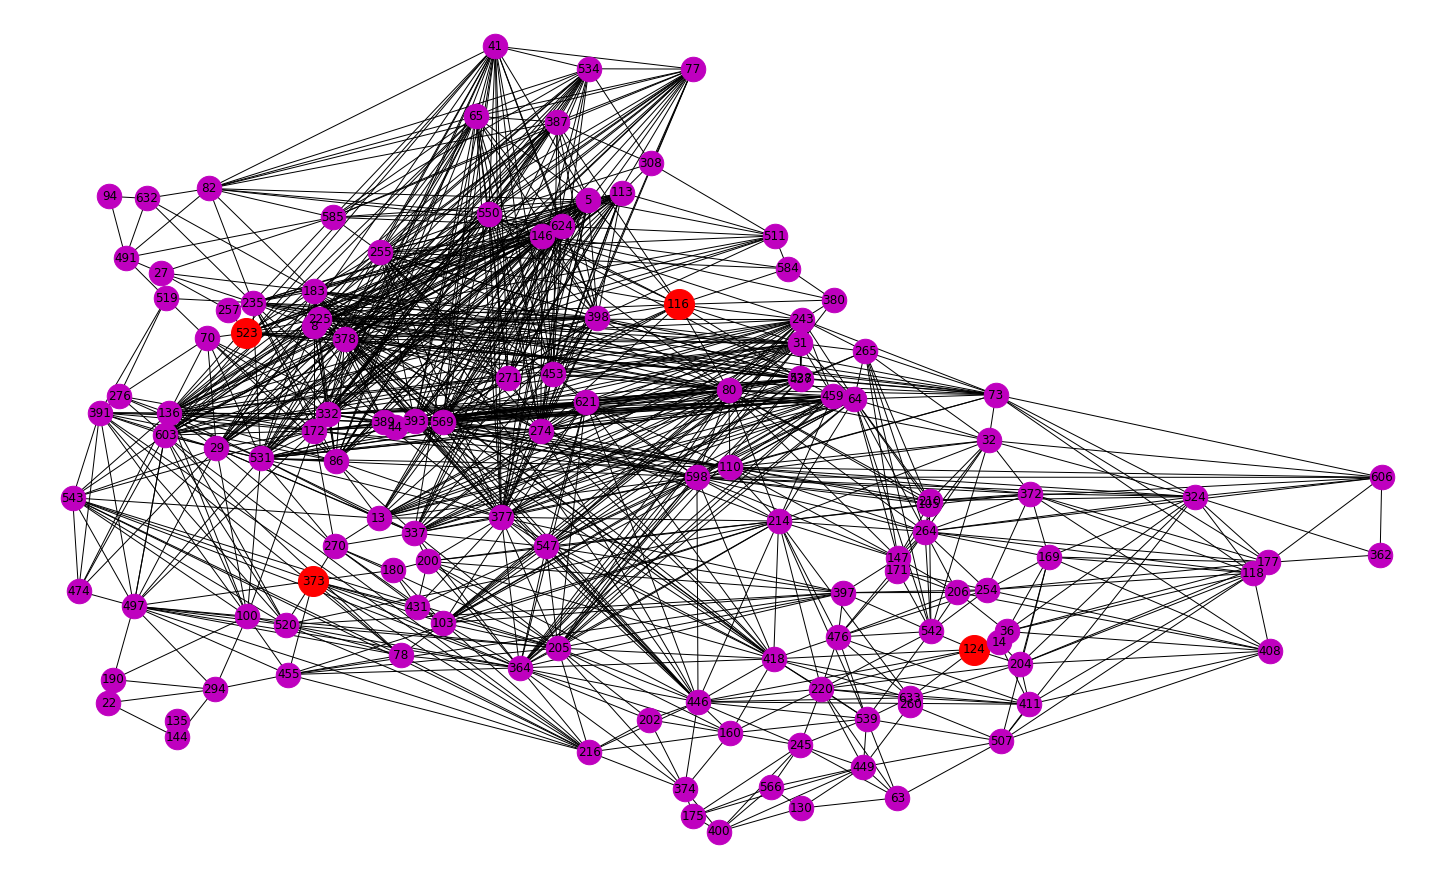

In [ ]:
pos_r = {k: v for k, v in pos.items() if k in list(nonroad_ids)}
plt.figure(figsize=(20, 12))
nx.draw(Gr1, with_labels=False, pos=pos_r, node_size=50)
nx.draw_networkx_nodes(
    Gr1, pos_r, nodelist=depot_loc_ids, node_color="r", node_size=900, alpha=1
)
nx.draw_networkx_labels(Gr1, pos_r, {k: k for k in depot_loc_ids})
nx.draw_networkx_nodes(
    Gr1, pos_r, nodelist=cust_loc_ids, node_color="m", node_size=600, alpha=1
)
nx.draw_networkx_labels(Gr1, pos_r, {k: k for k in cust_loc_ids});

In [ ]:
df_loc_r = data.copy()[data.id.isin(Gr1.nodes)]
df_loc_r

,id,x,y,is_depot,is_customer,capacity,level
5,5,49757.7778,6353.3333,False,True,0.5,0.40
8,8,49616.6667,6233.3333,False,True,2.0,1.80
13,13,49650.0000,6050.0000,False,True,1.0,0.80
14,14,49968.8889,5931.9444,False,True,1.0,0.67
22,22,49511.1111,5873.8889,False,True,2.0,0.32
...,...,...,...,...,...,...,...
606,606,50165.5556,6088.8889,False,True,1.5,0.06
621,621,49756.3889,6160.8333,False,True,1.5,1.26
624,624,49744.1667,6328.3333,False,True,1.0,0.49
632,632,49530.8333,6355.0000,False,True,1.5,0.26


In [ ]:
lorry_types = {'s': {'capacity': 5, 'cpm': 1.0, 'cptm': 1.5},
               'm': {'capacity': 12, 'cpm': 1.5, 'cptm': 1.0},
               'l': {'capacity': 22, 'cpm': 2.0, 'cptm': 0.5}}

def cpm(type, load):
    result = lorry_types[type]['cpm'] + load * lorry_types[type]['cptm']
    return result

In [ ]:
#import collections
from collections import Counter

In [ ]:
# create attribute dict to be added to graph
attrs = {n.id: {'x': n.x,
                'y': n.y,
                'is_cust': n.is_customer,
                'demand': float(f"{n.capacity - n.level:.2f}"),
                'dists': nx.single_source_dijkstra_path_length(Gr1, n.id)}
         for n in df_loc_r.itertuples()}

# replace NaN with 0 for depot demands
for d in depot_loc_ids:
    attrs[d]['demand'] = 0
    
# add lorry data to depot nodes
# note: the best_cpm attribute actually is the highest cpm, this is because best
# is referring to best lorry type, which will always have the worst cpm!
for d in depot_loc_ids:
    lorries = jdata[str(d)]
    #best_cap, best_num = max(collections.Counter([l['capacity'] for l in lorries]).items())
    best_cap, best_num = max(Counter([l['capacity'] for l in lorries]).items())
    best_cpm = max([l['cpm'] for l in lorries])
    best_cptm = min([l['cptm'] for l in lorries])
    attrs[d]['fleet'] = {'lorries': lorries,
                         'best_cap': best_cap,
                         'best_num': best_num,
                         'best_cpm': best_cpm,
                         'best_cptm': best_cptm}

# add attrs to graph
nx.set_node_attributes(Gr1, attrs)

In [ ]:
# split customers by closest depot
depot_list = list(depot_loc_ids)
nodes = Gr1.nodes
closest_depot = {c: depot_list[np.argmin([nodes[c]['dists'][d] for d in depot_list])] 
                     for c in nodes}

depot2cust = {}
for k, v in closest_depot.items():
    if k != v:
        depot2cust.setdefault(v, []).append(k)

cust_totals = {k: len(v) for k,v in depot2cust.items()}
        
#PP.pprint(depot2cust)
print(f"Total customers per depot: {cust_totals}")

Total customers per depot: {373: 30, 116: 32, 124: 40, 523: 21}


In [ ]:
reduced_nodes = list(Gr1.nodes)
data_r = data[data.id.isin(reduced_nodes)]
data_r
#print(reduced_nodes)
#len(reduced_nodes)

,id,x,y,is_depot,is_customer,capacity,level
5,5,49757.7778,6353.3333,False,True,0.5,0.40
8,8,49616.6667,6233.3333,False,True,2.0,1.80
13,13,49650.0000,6050.0000,False,True,1.0,0.80
14,14,49968.8889,5931.9444,False,True,1.0,0.67
22,22,49511.1111,5873.8889,False,True,2.0,0.32
...,...,...,...,...,...,...,...
606,606,50165.5556,6088.8889,False,True,1.5,0.06
621,621,49756.3889,6160.8333,False,True,1.5,1.26
624,624,49744.1667,6328.3333,False,True,1.0,0.49
632,632,49530.8333,6355.0000,False,True,1.5,0.26


Allocation 

In [ ]:
depot_list = list(depot_loc_ids)
closest_depot = {c: np.argmin([nx.shortest_path_length(Gr1, d, c, weight='weight') 
                 for d in depot_list]) 
                     for c in cust_loc_ids}

cust2depot = {c: depot_list[d] for c,d in closest_depot.items()}

depot2cust = {}
for k, v in cust2depot.items():
    depot2cust.setdefault(v, []).append(k)

print(depot2cust)
print("\n\n",{k: len(v) for k,v in depot2cust.items()})
#node_list=list(depot2cust)
#print(node_list[0:4])
values=depot2cust.values()
values_list=list(values)
value_tsp=values_list[0][0:33]
#value_tsp

{116: [5, 31, 32, 41, 64, 65, 73, 77, 80, 110, 113, 146, 243, 265, 271, 308, 380, 387, 393, 398, 437, 453, 459, 511, 528, 534, 550, 569, 584, 598, 621, 624], 523: [8, 27, 29, 70, 82, 94, 136, 183, 225, 235, 255, 257, 276, 332, 378, 391, 491, 519, 585, 603, 632], 373: [13, 22, 44, 78, 86, 100, 103, 135, 144, 172, 180, 190, 200, 205, 216, 270, 274, 294, 337, 364, 377, 389, 431, 455, 474, 497, 520, 531, 543, 547], 124: [14, 36, 63, 105, 118, 130, 147, 160, 169, 171, 175, 177, 202, 204, 206, 210, 214, 220, 245, 254, 260, 264, 324, 362, 372, 374, 397, 400, 408, 411, 418, 446, 449, 476, 507, 539, 542, 566, 606, 633]}


 {116: 32, 523: 21, 373: 30, 124: 40}


In [ ]:
# create subgraph for each depot - this contains all data for a single depot VRP
VRPs = {}
for d in depot_list:
    graph = Gr1.copy()
    remove = set(Gr1.nodes) - set(depot2cust[d]) - set([d]) # remove all the remaining customer and depo 
    graph.remove_nodes_from(remove)
    VRPs[d] = graph

In [ ]:
depot = 523
vrp = VRPs[depot]
nodes = vrp.nodes
custs = [c for c in nodes if nodes[c]['is_cust']]
print(custs)

[491, 8, 225, 94, 82, 27, 29, 276, 257, 255, 70, 519, 378, 183, 585, 332, 632, 136, 391, 235, 603]


In [ ]:
#get the data for the best vehicles available from the depot node data.
f = nodes[depot]['fleet']
cap, num_veh, cpm, cptm = (f[k] for k in list(f.keys())[1:])
cap, num_veh, cpm, cptm

(22, 1, 2.0, 0.5)

In [ ]:
tot_dem = sum([nodes[c]['demand'] for c in custs])
tot_dem

14.770000000000001

Allocation for Depo 523

In [ ]:
for i in depot_loc_ids:
    xd, yd = data_r[data_r.id == i].iloc[0, 1:3]
    data_r.loc[data_r.id.isin(depot2cust[i] + [i]),
                              ['x','y']] = data_r.loc[:, ['x','y']] - [xd, yd]
    data_r['demand'] = data_r.capacity - data_r.level
data_aco1=data_r[data_r.id.isin(depot2cust[523] + [523])]
data_aco1

C:\Users\nishantsiv\Anaconda3\envs\SOE\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  isetter(loc, v)
C:\Users\nishantsiv\Anaconda3\envs\SOE\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
C:\Users\nishantsiv\Anaconda3\envs\SOE\lib\site-packages\pandas\core\indexing.py:1717: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value inst

,id,x,y,is_depot,is_customer,capacity,level,demand
8,8,34.7223,6.6666,False,True,2.0,1.80,0.20
27,27,-43.8888,57.5000,False,True,1.5,0.48,1.02
29,29,-15.2777,-110.0000,False,True,1.5,0.96,0.54
70,70,-20.0000,-5.0000,False,True,1.5,0.04,1.46
82,82,-19.1666,137.7777,False,True,1.5,0.90,0.60
94,94,-70.2777,130.2777,False,True,2.0,0.48,1.52
136,136,-39.7222,-76.6667,False,True,0.5,0.16,0.34
183,183,34.7223,40.0000,False,True,1.5,1.10,0.40
225,225,37.5000,13.3333,False,True,1.5,0.86,0.64
235,235,3.3334,28.8889,False,True,0.5,0.14,0.36


In [ ]:
depot_cust_dfs = {d: data_r[data_r.id.isin(depot2cust[d] + [d])] 
                      for d in depot_list}
depot_cust_dfs = {d: depot_cust_dfs[d].sort_values(
                                by=['is_customer', 'id']).reset_index(drop=True) 
                      for d in depot_list}

depot_cust_dfs[523]

,id,x,y,is_depot,is_customer,capacity,level,demand
0,523,0.0000,0.0000,True,False,NaN,NaN,NaN
1,8,34.7223,6.6666,False,True,2.0,1.80,0.20
2,27,-43.8888,57.5000,False,True,1.5,0.48,1.02
3,29,-15.2777,-110.0000,False,True,1.5,0.96,0.54
4,70,-20.0000,-5.0000,False,True,1.5,0.04,1.46
5,82,-19.1666,137.7777,False,True,1.5,0.90,0.60
6,94,-70.2777,130.2777,False,True,2.0,0.48,1.52
7,136,-39.7222,-76.6667,False,True,0.5,0.16,0.34
8,183,34.7223,40.0000,False,True,1.5,1.10,0.40
9,225,37.5000,13.3333,False,True,1.5,0.86,0.64


In [ ]:
graphs = {} #define graph to plot aco1Graph
for d in depot_list:
    graph = Gr1.copy()
    remove = set(Gr1.nodes) - set(depot2cust[d]) - set([d])
    graph.remove_nodes_from(remove)
    graphs[d] = graph

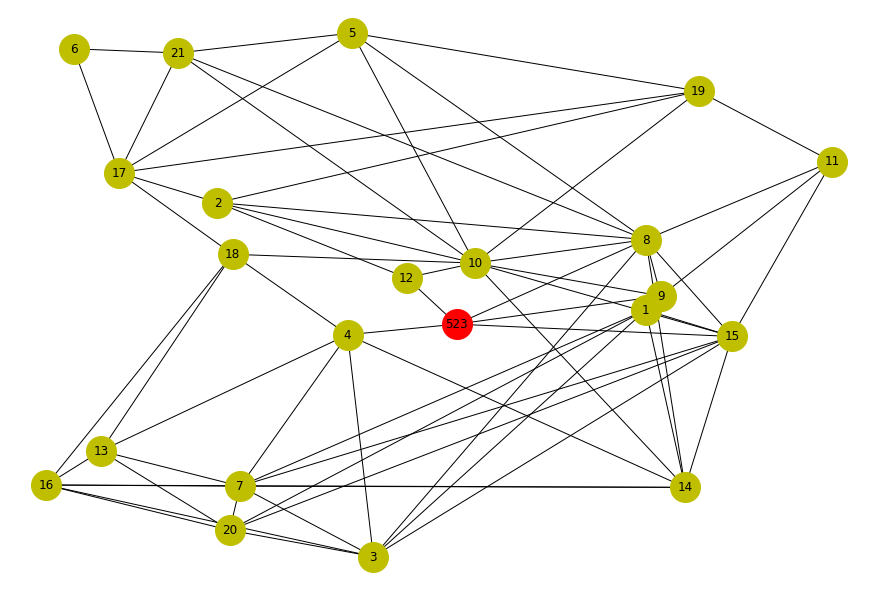

In [ ]:
depot = 523
nodes = depot_cust_dfs[depot]
G_aco = graphs[depot]
plt.figure(figsize=(12, 8))
pos = dict([(t.id, (t.x, t.y)) for t in depot_cust_dfs[depot].itertuples()])

nx.draw(G_aco, with_labels=False, pos=pos, node_size=50) # can comment this 
                                                     # to remove edges

nx.draw_networkx_nodes(
    G_aco, pos, nodelist=[depot], node_color="r", node_size=900, alpha=1
)
nx.draw_networkx_labels(G_aco, pos, {k: k for k in [depot]})
nx.draw_networkx_nodes(
    G_aco, pos, nodelist=depot2cust[depot], node_color="y", node_size=900, alpha=1
)
cust_ind = lambda c: nodes[nodes.id == c].index.values[0] # map to new index
nx.draw_networkx_labels(G_aco, pos, {k: cust_ind(k) for k in depot2cust[depot]})
plt.axis('off');

In [ ]:
dist_aco1 =squareform(pdist(data_aco1[['x','y']]))

In [ ]:
dist_aco1[:5]
#dist_aco1.shape

array([[  0.        ,  93.61484711, 126.92949049,  55.95211947,
        141.7537798 , 162.18724994, 111.74266181,  33.3334    ,
          7.22222308,  38.45898673,  78.14298259,  46.47199927,
        120.18500554,  84.19921446,  20.1728379 , 137.66679926,
        116.48798603,  80.29370211,  35.35649407, 104.06623475,
        129.17408641, 148.89646888],
       [ 93.61484711,   0.        , 169.92599873,  66.90982563,
         83.99819218,  77.41426006, 134.23138211,  80.53542726,
         92.6004004 ,  55.21350574, 114.44166334,  49.69740299,
        119.43087977, 159.74183393, 113.71395801, 137.24863965,
         22.94988555,  24.60181289,  72.33586085, 102.89925902,
        155.01592877,  71.20054779],
       [126.92949049, 169.92599873,   0.        , 105.10613739,
        247.80821649, 246.49213602,  41.33572872, 158.11388301,
        134.15136416, 140.13029503, 205.0176218 , 132.08584419,
         70.71067812,  65.94511195, 123.22623075,  68.90905269,
        187.56474734, 145.3693

ACO Hyperparameter 

In [ ]:
#import random
import random as rn
import numpy as np
from numpy.random import choice as np_choice
import pdb

In [ ]:
#iteration = 500
#m = 22 #number of ant 
#n = 22 # number of nodes
#e = .05         #evaporation rate
#alpha = 1     #pheromone factor
#beta = 3     #visibility factor
#tau=.1*np.ones((m,n))  #initial phermone level
#eta=1/dist_aco1    # Visibility more the visibility less the distance
#eta[eta == inf ] = 0

In [ ]:
class AntColony(object):
    
    def __init__(self, distances, n_ants, n_best, n_iterations, decay, alpha=1, beta=1):#init method
          # work as a constructor 4 a class,for connecting methods to the instance of class, n_best keep the best ant
            self.distances  = distances
            self.pheromone = np.ones(self.distances.shape) / len(distances)
            self.all_inds = range(len(distances))
            self.n_ants = n_ants
            self.n_best = n_best
            self.n_iterations = n_iterations
            self.decay = decay
            self.alpha = alpha
            self.beta = beta
    def main_loop(self):
        rn.seed(42)
        shortest_path = None
        all_time_shortest_path = ("placeholder", np.inf)# keep updating initialise to infinity
        for i in range(self.n_iterations):
            all_paths = self.gen_all_paths() #call gen_all_path function
            self.spread_pheronome(all_paths, self.n_best, shortest_path=shortest_path)
            shortest_path = min(all_paths, key=lambda x: x[1])  #need not to close the loop
            #shortest_path = min(all_paths)
            ##print (shortest_path)
            #pdb.set_trace()
            if shortest_path[1] < all_time_shortest_path[1]:
                all_time_shortest_path = shortest_path            
            self.pheromone * self.decay            
        return all_time_shortest_path
    def spread_pheronome(self, all_paths, n_best, shortest_path):
        sorted_paths = sorted(all_paths, key=lambda x: x[1])
        #sorted_paths = sorted(all_paths)
        for path, dist in sorted_paths[:n_best]:
            for move in path:
                self.pheromone[move] += 1.0 / self.distances[move]#updated amount of phermone 
    def gen_path_dist(self, path):
        total_dist = 0
        for _ in path:
            total_dist += self.distances[_]
            #print(total_dist)
        return total_dist
    def gen_all_paths(self):
        all_paths = []# all path variable set in empty list TABU LIST
        for i in range(self.n_ants):
            path = self.gen_path(21)# start the path Depo 4 us 21is 523
            all_paths.append((path, self.gen_path_dist(path)))# path and distance of the path
        return all_paths
    def gen_path(self, start):
        path = []
        visited = set()
        visited.add(start)
        prev = start
        for i in range(len(self.distances) - 1):
        #for i in range(len(self.distances)):    
            move = self.pick_move(self.pheromone[prev], self.distances[prev], visited)
            path.append((prev, move))
            prev = move #next location turn to current location
            visited.add(move) # add to visted list
        path.append((prev, start)) # going back to where we started 
        #path.append((prev))
        return path
    
    def pick_move(self, pheromone, dist, visited): #probability of selecting node(roullte wheel op*)
        pheromone = np.copy(pheromone)
        pheromone[list(visited)] = 0# already visited nodes

        row = pheromone ** self.alpha * (( 1.0 / dist) ** self.beta)#probability for choosing path

        norm_row = row / row.sum()
        move = np_choice(self.all_inds, 1, p=norm_row)[0] #random choice for node
        return move
    

In [ ]:
def route_cost(self,paths):
    cost = 0
    load = sum([nodes[c]['demand'] for c in gen_all_paths])
    cost += (cpm + cptm * load) * nodes[depot]['dists'][route[0]]
    print(cost)
    load -= nodes[paths[0]]['demand']
    for begin, end in zip(gen_all_paths[:-1], gen_all_paths[1:]):            
        dist = nodes[begin]['dists'][end]
        cost += (cpm + cptm * load) * dist
        load -= nodes[end]['demand']
    if not open:
        cost += cpm * nodes[gen_all_paths[-1]]['dists'][depot]
        print(cost)
    return cost
#def routes_cost(routes, openflags):
    #return sum((route_cost(r, o) for r,o in zip(routes, openflags)))

In [ ]:
def fitness_function (self,route_cost, dist_aco1):
    print(cost)

In [ ]:
distances=dist_aco1

In [ ]:


for i in range(len(data_aco1)):
    distances[i][i]=np.inf

In [ ]:
ant_colony = AntColony(distances, 22, 1, 1000, 0.05, alpha=1, beta=1)

In [ ]:
shortest_path = ant_colony.main_loop()
print ("shorted_path: {}".format(shortest_path))

shorted_path: ([(21, 5), (5, 16), (16, 1), (1, 17), (17, 11), (11, 9), (9, 18), (18, 3), (3, 12), (12, 15), (15, 6), (6, 20), (20, 2), (2, 13), (13, 14), (14, 0), (0, 8), (8, 7), (7, 10), (10, 19), (19, 4), (4, 21)], 786.0466840752347)
